In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [19]:
from fastai.conv_learner import *
from pathlib import Path
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, models
from MyUtils import LR_Scheduler

In [20]:
PATH = Path('data')
PATH_TRN = PATH/'train'

In [21]:
fnames_full,label_arr_full,all_labels = folder_source(PATH, 'train')
fnames_full = ['/'.join(Path(fn).parts[-2:]) for fn in fnames_full]
list(zip(fnames_full[:5],label_arr_full[:5]))

[('n01440764/n01440764_6878.JPEG', 0),
 ('n01440764/n01440764_9567.JPEG', 0),
 ('n01440764/n01440764_14405.JPEG', 0),
 ('n01440764/n01440764_11787.JPEG', 0),
 ('n01440764/n01440764_3421.JPEG', 0)]

In [22]:
all_labels[:5]

['n01440764', 'n01443537', 'n01491361', 'n01494475', 'n01498041']

In [23]:
np.random.seed(42)
keep_pct = 1.
keeps = np.random.rand(len(fnames_full)) < keep_pct
fnames = np.array(fnames_full, copy=False)[keeps]
label_arr = np.array(label_arr_full, copy=False)[keeps]

In [24]:
arch = models.vgg16_bn(pretrained=True)
sz_lr = 72

In [25]:
scale, bs = 2, 64
sz_hr = sz_lr*scale

In [26]:
tfms = transforms.Compose([
    transforms.Resize((sz_lr,sz_lr)),
    transforms.ToTensor()
])
l_tfms = transforms.Compose([transforms.Resize((sz_hr,sz_hr)), transforms.ToTensor()])

In [27]:
val_idxs = get_cv_idxs(len(fnames), val_pct=min(0.01/keep_pct, 0.1))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, np.array(fnames), np.array(fnames))
len(val_x),len(trn_x)

(194, 19245)

In [28]:
class custom_data(Dataset):
    def __init__(self, path, x):
        super().__init__()
        self.path = path
        self.x = x
        
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, index):
        img_name = self.x[index]
        img = Image.open(self.path/img_name).convert('RGB')
        img_t = tfms(img)
        label = l_tfms(img)
        return (img_t, label)

In [29]:
trn = custom_data(PATH_TRN, trn_x)
val = custom_data(PATH_TRN, val_x)

In [30]:
trn = DataLoader(trn, batch_size=bs, shuffle=True)
val = DataLoader(val, batch_size=bs, shuffle=True)

In [31]:
def show_img(ims, idx, figsize=(5,5), normed=True, ax=None):
    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    ims = np.rollaxis(to_np(ims),1,4)
    ax.imshow(np.clip(ims,0,1)[idx])
    ax.axis('off')

In [15]:
x,y = next(iter(val))
x.size(),y.size()

(torch.Size([64, 3, 72, 72]), torch.Size([64, 3, 144, 144]))

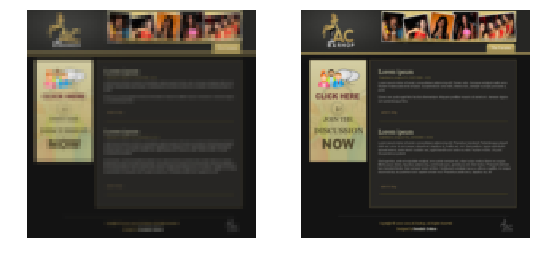

In [16]:
idx=1
fig,axes = plt.subplots(1, 2, figsize=(9,5))
show_img(x,idx, ax=axes[0])
show_img(y,idx, ax=axes[1])

In [32]:
def conv(ni, nf, kernel_size=3, actn=False):
    layers = [nn.Conv2d(ni, nf, kernel_size, padding=kernel_size//2)]
    if actn: layers.append(nn.ReLU(True))
    return nn.Sequential(*layers)

In [33]:
class ResSequential(nn.Module):
    def __init__(self, layers, res_scale=1.0):
        super().__init__()
        self.res_scale = res_scale
        self.m = nn.Sequential(*layers)
    def forward(self, x): return x + self.m(x) * self.res_scale

In [34]:
def res_block(nf):
    return ResSequential([conv(nf, nf, actn=True), conv(nf, nf)],
                        0.1)

In [35]:
def upsample(ni, nf, scale):
    layers = []
    for i in range(int(math.log(scale,2))):
        layers += [conv(ni, nf*4), nn.PixelShuffle(2)]
    return nn.Sequential(*layers)

In [36]:
class SrResnet(nn.Module):
    def __init__(self, nf, scale):
        super().__init__()
        features = [conv(3,64)]
        for i in range(8): features.append(res_block(64))
        features += [conv(64,64), upsample(64,64, scale),
                    nn.BatchNorm2d(64),
                    conv(64,3)]
        self.features = nn.Sequential(*features)
    def forward(self, x): return self.features(x)

In [37]:
lr = 1e-5
m = to_gpu(SrResnet(64, scale))
optimizer = torch.optim.Adam(m.parameters(), lr=lr)

In [38]:
def train(data, model, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        random.seed()
        tq = tqdm(total=len(data)*bs)
        tq.set_description(f'Epoch {epoch}, lr {lr}')
        losses = []
        for i, (inputs, targets) in enumerate(data):
            inputs = Variable(inputs.cuda())
            targets = Variable(targets.cuda())
            LR_Scheduler(lr, num_epochs)
            outputs = model(inputs)
            loss = F.mse_loss(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            tq.update(bs)
            tq.set_postfix(loss=f'{loss.data.cpu()[0]}')
        tq.close()

In [25]:
train(trn, m, 2)

Epoch 1, lr 1e-05: 100%|██████████| 19264/19264 [11:35<00:00, 28.83it/s, loss=0.17465852200984955]


In [26]:
x,y = next(iter(val))
preds = m(VV(x))

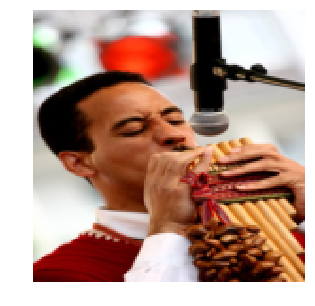

In [27]:
show_img(y,idx)

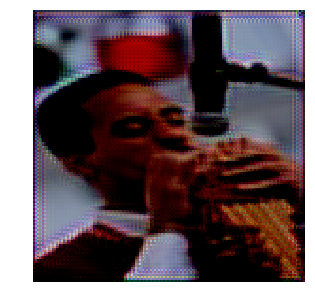

In [28]:
show_img(preds,idx)

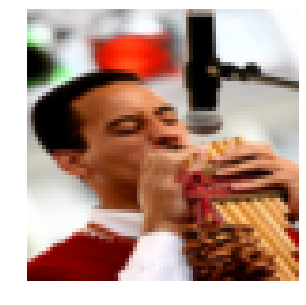

In [29]:
show_img(x,idx)

In [39]:
def icnr(x, scale=2, init=nn.init.kaiming_normal):
    new_shape = [int(x.shape[0]/(scale**2))] + list(x.shape[1:])
    subkernel = torch.zeros(new_shape)
    subkernel = init(subkernel)
    subkernel = subkernel.transpose(0,1)
    subkernel = subkernel.contiguous().view(subkernel.shape[0],
                                           subkernel.shape[1], -1)
    kernel = subkernel.repeat(1,1,scale**2)
    transposed_shape = [x.shape[1]] + [x.shape[0]] + list(x.shape[2:])
    kernel = kernel.contiguous().view(transposed_shape)
    kernel = kernel.transpose(0,1)
    return kernel

In [53]:
# m_vgg = arch
m_vgg = vgg16(True)

In [54]:
# blocks = [i-1 for i,o in enumerate(m_vgg.modules())
#          if isinstance(o, nn.MaxPool2d)]
blocks = [i-1 for i,o in enumerate(children(m_vgg))
              if isinstance(o,nn.MaxPool2d)]
blocks, [m_vgg[i] for i in blocks]

([5, 12, 22, 32, 42],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [46]:
# blocks, [list(m_vgg.modules())[i] for i in blocks]

([7, 14, 24, 34, 44],
 [ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace), ReLU(inplace)])

In [55]:
# vgg_layers = list(m_vgg.modules())[:25]
# m_vgg = nn.Sequential(*vgg_layers).cuda().eval()
# set_trainable(m_vgg, False)
vgg_layers = children(m_vgg)[:23]
m_vgg = nn.Sequential(*vgg_layers).cuda().eval()
set_trainable(m_vgg, False)

In [56]:
def flatten(x): return x.view(x.size(0), -1)

In [57]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove() 

In [58]:
class FeatureLoss(nn.Module):
    def __init__(self, m, layer_ids, layer_wgts):
        super().__init__()
        self.m,self.wgts = m,layer_wgts
        self.sfs = [SaveFeatures(m[i]) for i in layer_ids]

    def forward(self, input, target, sum_layers=True):
        self.m(VV(target.data))
        res = [F.l1_loss(input,target)/100]
        targ_feat = [V(o.features.data.clone()) for o in self.sfs]
        self.m(input)
        res += [F.l1_loss(flatten(inp.features),flatten(targ))*wgt
               for inp,targ,wgt in zip(self.sfs, targ_feat, self.wgts)]
        if sum_layers: res = sum(res)
        return res
    
    def close(self):
        for o in self.sfs: o.remove()

In [59]:
m = SrResnet(64, scale)

In [60]:
conv_shuffle = m.features[10][0][0]
kernel = icnr(conv_shuffle.weight, scale=scale)
conv_shuffle.weight.data.copy_(kernel);

In [61]:
m = to_gpu(m)


In [62]:
for i in range(10,13): set_trainable(m.features[i], True)

In [63]:
lr=6e-3
wd=1e-7

In [64]:
optimizer = torch.optim.Adam(m.parameters(), lr=lr, weight_decay=wd)
Loss = FeatureLoss(m_vgg, blocks[:3], [0.2,0.7,0.1])

In [65]:
def train(data, model, num_epochs):
    for epoch in range(num_epochs):
        model.train()
        random.seed()
        tq = tqdm(total=len(data)*bs)
        tq.set_description(f'Epoch {epoch}, lr {lr}')
        losses = []
        for i, (inputs, targets) in enumerate(data):
            inputs = Variable(inputs.cuda())
            targets = Variable(targets.cuda())
            LR_Scheduler(lr, num_epochs)
            outputs = model(inputs)
            loss = Loss(outputs, targets)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            tq.update(bs)
            tq.set_postfix(loss=f'{loss.data.cpu()[0]}')
        tq.close()

In [66]:
train(trn, m, 2)

Epoch 1, lr 0.006: 100%|██████████| 19264/19264 [17:19<00:00, 20.63it/s, loss=0.05222581699490547] 


In [69]:
def plot_ds_img(idx, ax=None, figsize=(7,7), normed=True):
    if ax is None: fig,ax = plt.subplots(figsize=figsize)
    im = val.dataset[idx][0]
    im = np.rollaxis(to_np(im),0,3)
    ax.imshow(im)
    ax.axis('off')

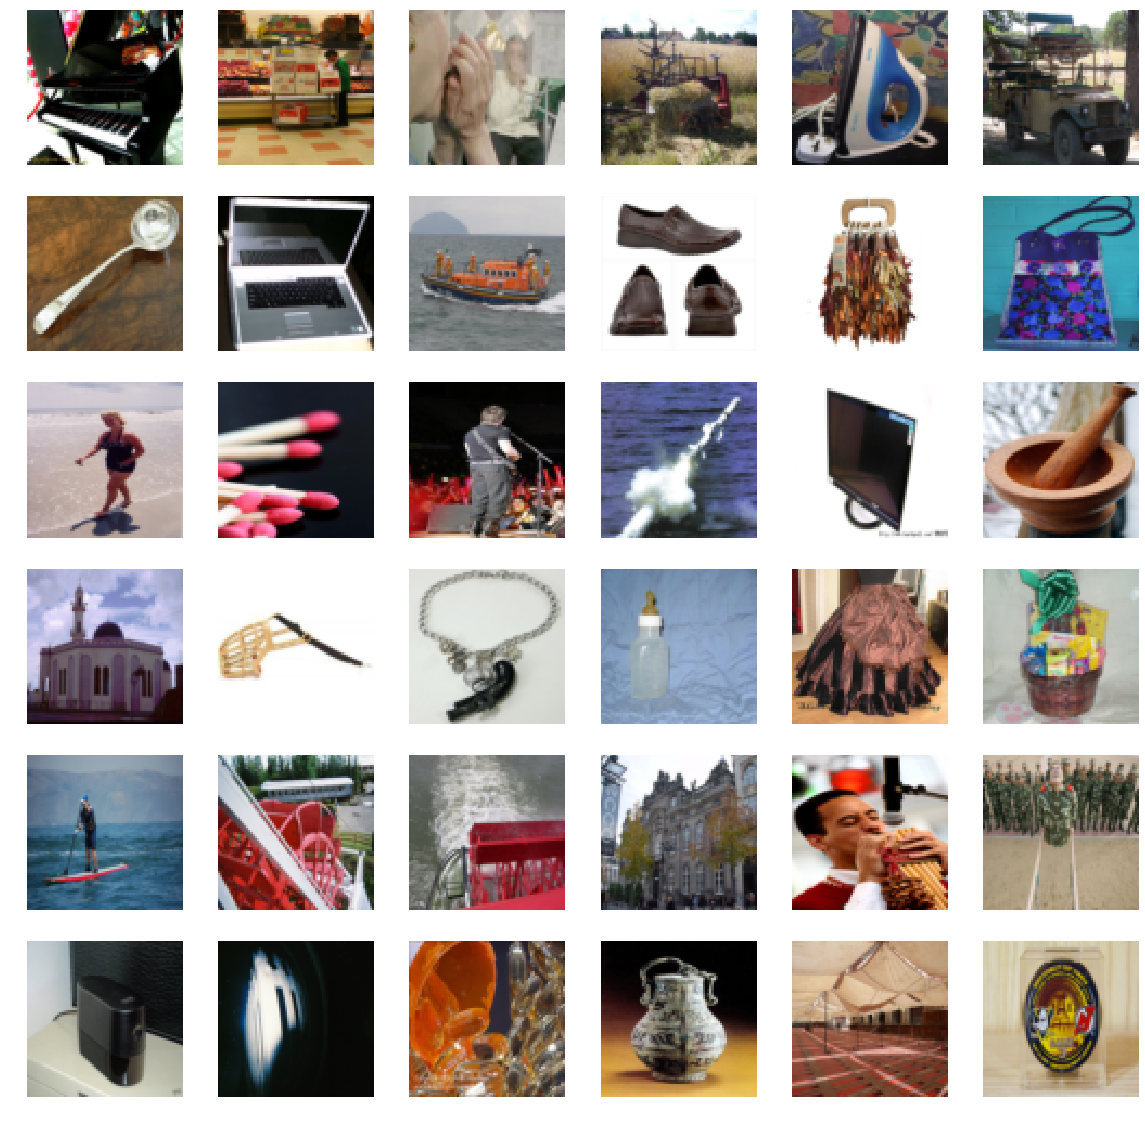

In [71]:
fig,axes=plt.subplots(6,6,figsize=(20,20))
for i,ax in enumerate(axes.flat): plot_ds_img(i+100,ax=ax, normed=True)

In [79]:
x,y = next(iter(val))

In [85]:
m.eval()
preds = m(VV(x))
x.shape,y.shape,preds.shape

(torch.Size([64, 3, 72, 72]),
 torch.Size([64, 3, 144, 144]),
 torch.Size([64, 3, 144, 144]))

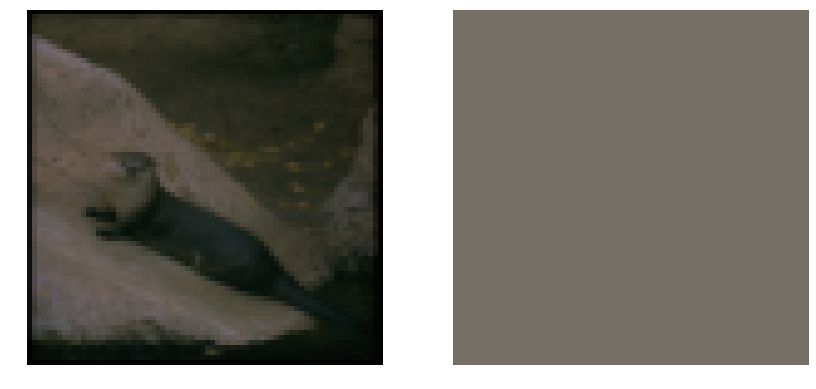

In [81]:
_,axes=plt.subplots(1,2,figsize=(14,7))
show_img(x, 0, ax=axes[0])
show_img(preds,0, normed=True, ax=axes[1])

In [86]:
preds

Variable containing:
( 0 , 0 ,.,.) = 
  4.6308e-01  4.6899e-01  4.6899e-01  ...   4.6899e-01  4.6899e-01  4.2855e-01
  4.5048e-01  4.5916e-01  4.5916e-01  ...   4.5916e-01  4.5916e-01  4.4826e-01
  4.5048e-01  4.5916e-01  4.5916e-01  ...   4.5916e-01  4.5916e-01  4.4826e-01
                 ...                   ⋱                   ...                
  4.5048e-01  4.5916e-01  4.5916e-01  ...   4.5916e-01  4.5916e-01  4.4826e-01
  4.5048e-01  4.5916e-01  4.5916e-01  ...   4.5916e-01  4.5916e-01  4.4826e-01
  4.4092e-01  4.7140e-01  4.7140e-01  ...   4.7140e-01  4.7140e-01  4.4936e-01

( 0 , 1 ,.,.) = 
  4.3449e-01  4.3170e-01  4.3170e-01  ...   4.3170e-01  4.3170e-01  4.0686e-01
  4.4057e-01  4.3693e-01  4.3693e-01  ...   4.3693e-01  4.3693e-01  4.3806e-01
  4.4057e-01  4.3693e-01  4.3693e-01  ...   4.3693e-01  4.3693e-01  4.3806e-01
                 ...                   ⋱                   ...                
  4.4057e-01  4.3693e-01  4.3693e-01  ...   4.3693e-01  4.3693e-01  4.3806e